![UoE](./docs/dc.jpg)

# RNAseq Coursework - Processing and analysis of high throughput RNA sequencing data

KS Singh<sup>1\*</sup>

<sup>1</sup>College of Life and Environmental Sciences;
Penryn Campus, University of Exeter TR10 9FE Cornwall UK

<sup>\*</sup> Correspondence: <ks575@exeter.ac.uk>

## Abstract
This workshop summarizes the main approaches to analyzing RNAseq data using reference based methodology. It demonstrates approaches to pre-process short-read paired-end sequencing data, mapping short-reads against reference genome, summarizing count data followed by differential expression analysis using a Bioconductor package, Ballgown. 

We will start from the FASTQ files, show how these reads in the fastq files are aligned to the reference genome, and prepare a count matrix which shows the number of RNA-seq reads/fragments within each gene for each sample. We will perform exploratory data analysis (EDA) for quality assessment and to explore the relationship between samples, perform differential gene expression analysis, and visually explore the results.

1. [Introduction](#introduction)
2. [Pre-processing of sequencing data](#pre-processing)
3. [Read mapping](#mapping)
4. [Transcript assembly](#mapping)
5. [Differential expression analysis](#dge)
6. [*de-novo* transcriptome assembly](#de-novo-transcriptome-assembly)


## Introduction <a name="introduction"></a>


### Sequencing technology

In [1]:
%%HTML

<h4>Intrduction to Next Generation Sequencing</h4>

<iframe width="560" height="315" src="https://www.youtube.com/embed/ToKUGz_YhC4" frameborder="0" allowfullscreen="true"></iframe>

<h4>Introduction to Illumina sequencing</h4>
<iframe width="560" height="315" src="https://www.youtube.com/embed/womKfikWlxM" frameborder="0" allowfullscreen="true"></iframe>


### RNA sequencing

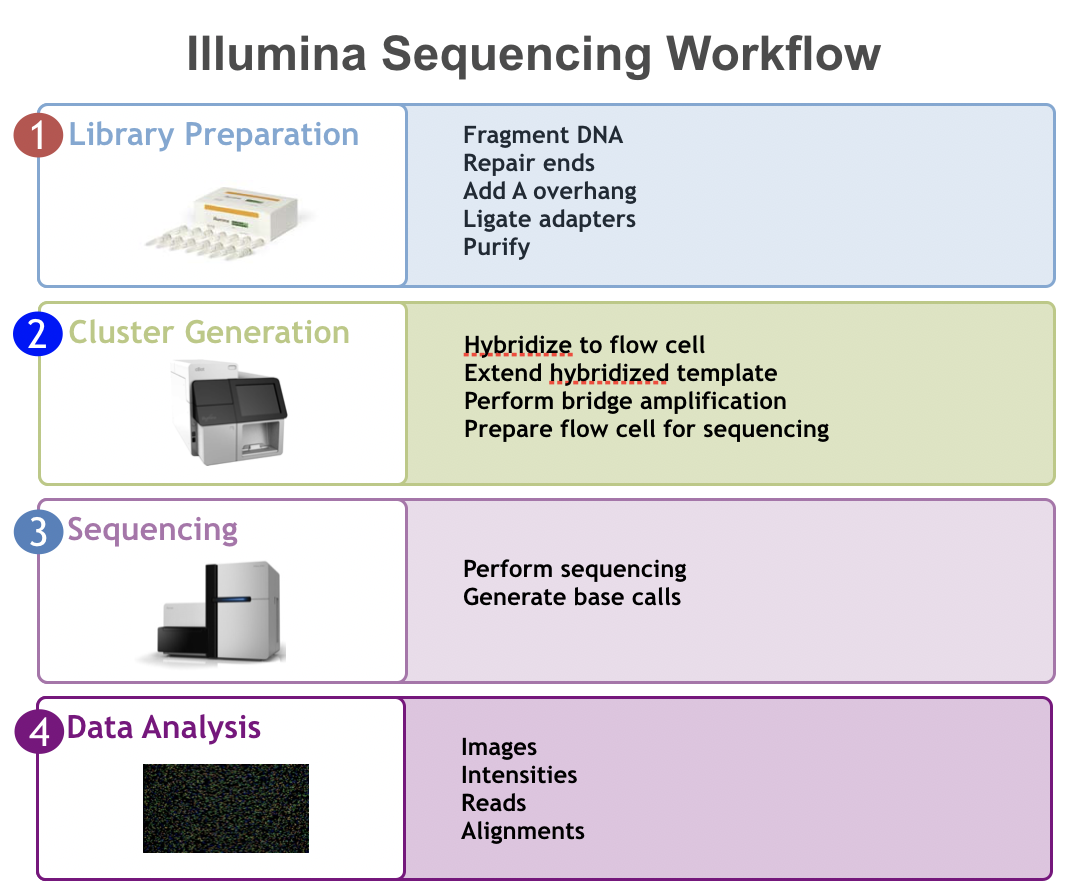

In [2]:
from IPython.display import Image
Image(filename="./docs/Fig1.png", width=400, height=400)

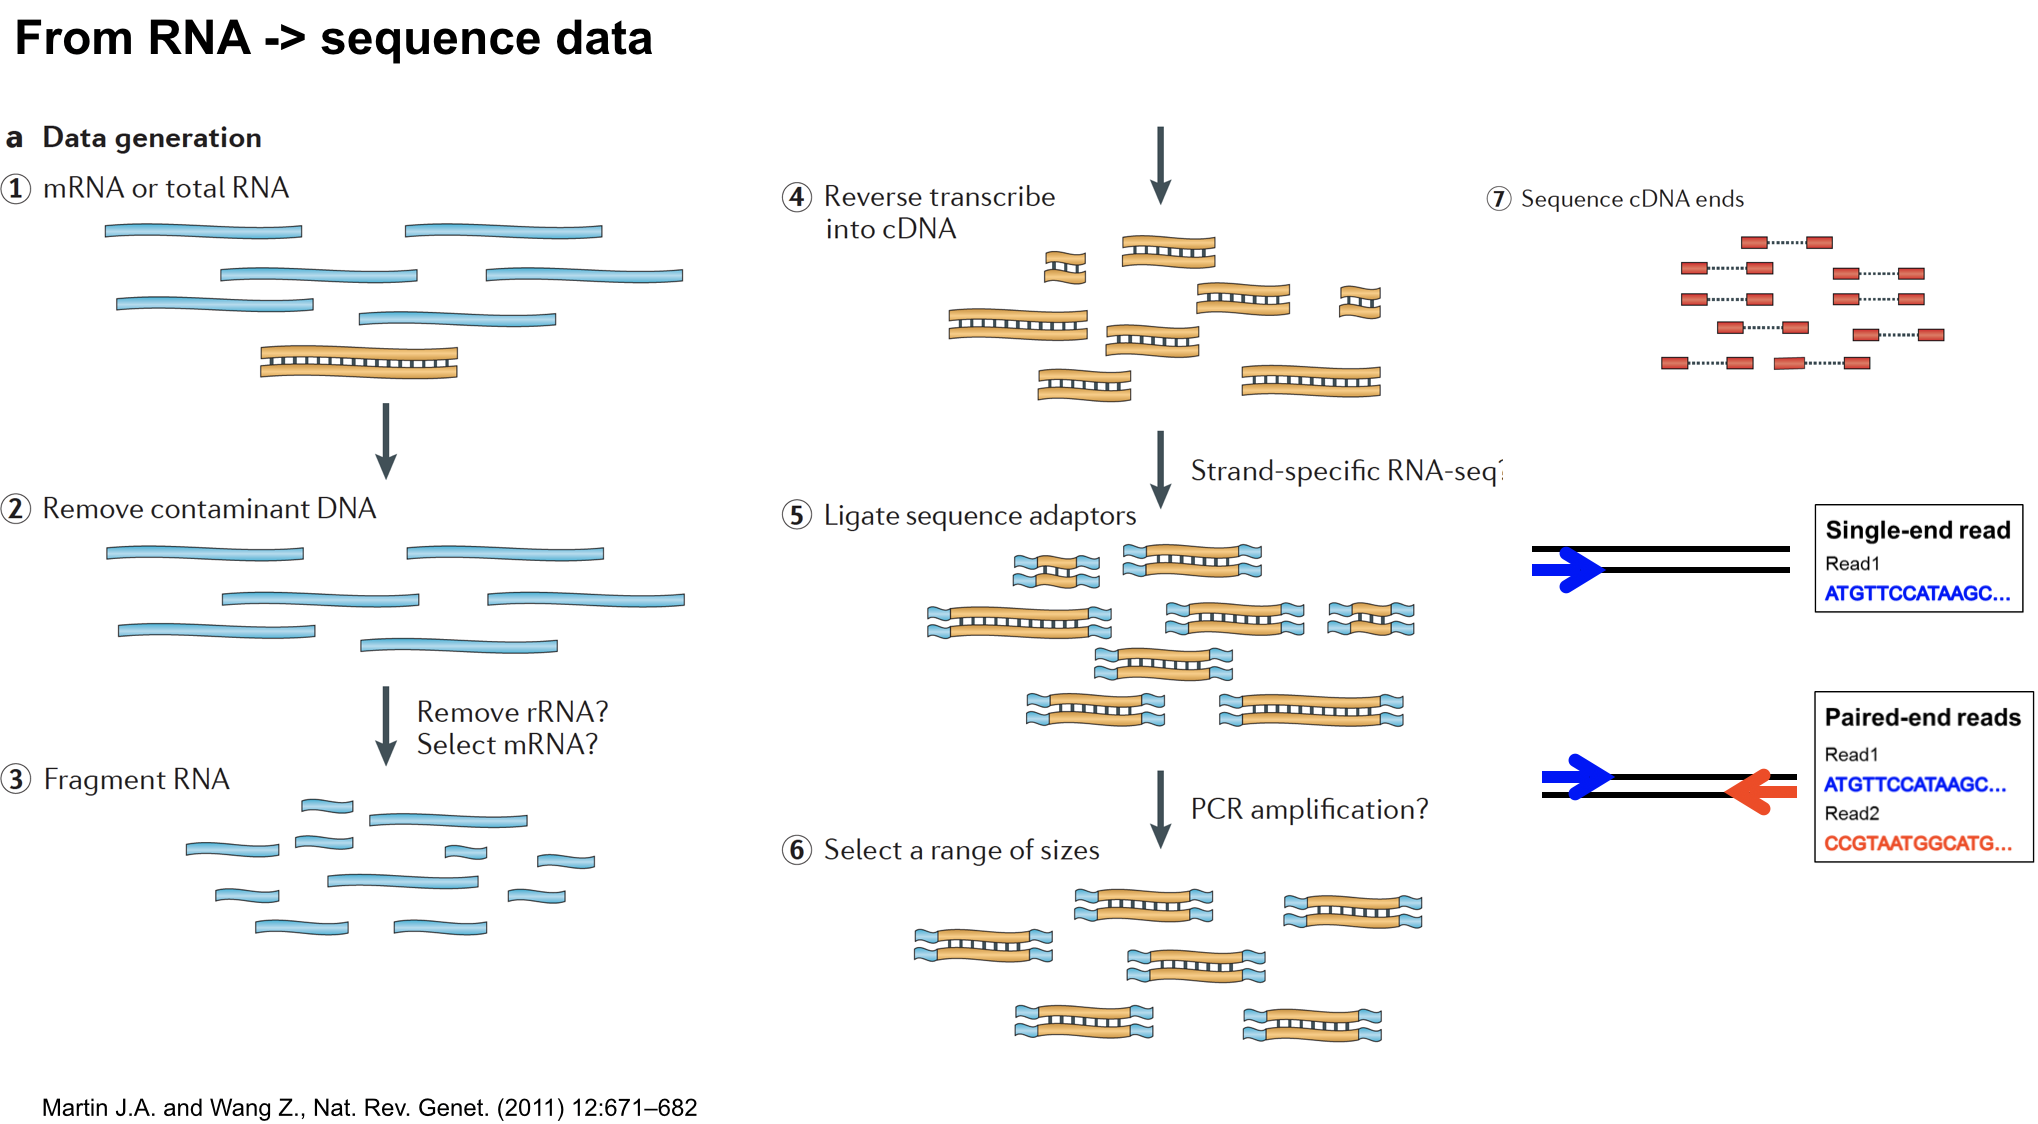

In [8]:
from IPython.display import Image
Image(filename="./docs/Fig2.png", width=800, height=800)

### File formats

#### GTF/GFF format (http://ccb.jhu.edu/software/stringtie/gff.shtml)

Many bioinformatics programs represent genes and transcripts in GFF format (General Feature Format) which simply describes the locations and the attributes of gene and transcript features on the genome (chromosome or scaffolds/contigs). GFF has many versions, but the two most popular that are GTF2 (Gene Transfer Format) and GFF3. Here are a few details about the way these formats are interpreted by bioinformatics programs.

**GTF file**

As seen in the GTF2 specification, the transcript_id attribute is required, so our GFF parser also expects it, while a gene_id attribute, though not strictly required by our GFF parser, is very useful for grouping alternative transcripts under a gene/locus identifier. An optional gene_name attribute, if found, will be taken and shown as  a symbolic gene name or short-form abbreviation (e.g. gene symbols from HGNC or Entrez Gene). Some annotation sources (e.g. Ensembl) place a "human readable" gene name/symbol in the gene_name attribute, like a HUGO symbol (while gene_id might be just an automatically generated numeric identifier for the gene). 

Most bioinformatics programs generally expect at least the exon features which are enough to define the overall transcript structure, with optional CDS features to specify the coding segments. Our GFF reader will ignore redundant features like start_codon, stop_codon when whole CDS features were provided, and similarly UTR features are ignored when whole exon features were given. However, it is still possible to provide only CDS and UTR features and our GFF parser will reassemble the exonic structure accordingly (internally converting these segments to exon segments). The GTF output of programs like StringTie and Cufflinks also have an additional transcript feature line acting as a parent feature for the exon and CDS features which define the transcript structure and have the same transcript_id attribute. This is not required by the GTF2 specification (and makes such files more similar to GFF3, which always have a "parent" feature, see below) but may be useful for holding the global attributes of each transcript (instead of having them duplicated for each exon feature).

In [7]:
%%bash
#ls -la ./genome/
head ./genome/Drosophila_melanogaster.BDGP6.94.chr.gtf

#!genome-build BDGP6
#!genome-version BDGP6
#!genome-date 2014-07
#!genome-build-accession GCA_000001215.4
3R	FlyBase	gene	567076	2532932	.	+	.	gene_id "FBgn0267431"; gene_name "Myo81F"; gene_source "FlyBase"; gene_biotype "protein_coding";
3R	FlyBase	transcript	567076	2532932	.	+	.	gene_id "FBgn0267431"; transcript_id "FBtr0392909"; gene_name "Myo81F"; gene_source "FlyBase"; gene_biotype "protein_coding"; transcript_name "Myo81F-RB"; transcript_source "FlyBase"; transcript_biotype "protein_coding";
3R	FlyBase	exon	567076	567268	.	+	.	gene_id "FBgn0267431"; transcript_id "FBtr0392909"; exon_number "1"; gene_name "Myo81F"; gene_source "FlyBase"; gene_biotype "protein_coding"; transcript_name "Myo81F-RB"; transcript_source "FlyBase"; transcript_biotype "protein_coding"; exon_id "FBtr0392909-E1";
3R	FlyBase	exon	835376	835491	.	+	.	gene_id "FBgn0267431"; transcript_id "FBtr0392909"; exon_number "2"; gene_name "Myo81F"; gene_source "FlyBase"; gene_biotype "protein_coding"; transcript_name 

**GFF3 file**

As defined by the GFF3 specification, the parent features (usually transcripts, i.e. "mRNA" features) are required to have an ID attribute, but here again an optional gene_name attribute can be used to specify a common gene name abbreviation. If gene_name is not given, it can be also inferred from the Name or ID attributes of the parent gene feature of the current parent mRNA feature (if given in the input file). CDS and exon features are required to have a Parent attribute whose value must match the value of the ID attribute of a parent transcript feature (usually a "mRNA" feature).

In [11]:
%%bash
#ls -la ./genome/
head -n 20 ./genome/Drosophila_melanogaster.BDGP6.94.chr.gff3

##gff-version 3
##sequence-region   2L 1 23513712
##sequence-region   2R 1 25286936
##sequence-region   3L 1 28110227
##sequence-region   3R 1 32079331
##sequence-region   4 1 1348131
##sequence-region   X 1 23542271
##sequence-region   Y 1 3667352
##sequence-region   mitochondrion_genome 1 19517
#!genome-build FlyBase BDGP6
#!genome-version BDGP6
#!genome-date 2014-07
#!genome-build-accession GCA_000001215.4
2L	FlyBase	chromosome	1	23513712	.	.	.	ID=chromosome:2L;Alias=AE014134.6,NT_033779.5
###
2L	FlyBase	gene	7529	9484	.	+	.	ID=gene:FBgn0031208;Name=CG11023;biotype=protein_coding;gene_id=FBgn0031208;logic_name=flybase
2L	FlyBase	mRNA	7529	9484	.	+	.	ID=transcript:FBtr0300689;Parent=gene:FBgn0031208;Name=CG11023-RB;biotype=protein_coding;transcript_id=FBtr0300689
2L	FlyBase	five_prime_UTR	7529	7679	.	+	.	Parent=transcript:FBtr0300689
2L	FlyBase	exon	7529	8116	.	+	.	Parent=transcript:FBtr0300689;Name=FBtr0330654-E1;constitutive=1;ensembl_end_phase=2;ensembl_phase=-1;exon_id=FBtr033065

**Feature restrictions**

For various reasons GFF parser currently assumes the following limits (maximum values) for the genomic length (span) of gene and transcript features:
1. genes and transcripts should not span more than 7 Megabases on the genomic sequence.
2. exons should not be longer than 30 Kilobases.
3. introns should not be larger than 6 Megabases.

Also, transcript IDs are expected to be unique per GFF input file (though cufflinks and StringTie relaxed this restriction by limiting it to a chromosome/contig scope).

#### FASTA/Q format

the **FASTA** format is a text-based format for representing either nucleotide sequences or amino acid (protein) sequences, in which nucleotides or amino acids are represented using single-letter codes. The format also allows for sequence names and comments to precede the sequences.


In [13]:
%%bash
#ls -la ./genome/
head ./genome/Drosophila_melanogaster.BDGP6_merged.fasta

>2L dna:chromosome chromosome:BDGP6:2L:1:23513712:1 REF
CGACAATGCACGACAGAGGAAGCAGAACAGATATTTAGATTGCCTCTCATTTTCTCTCCC
ATATTATAGGGAGAAATATGATCGCGTATGCGAGAGTAGTGCCAACATATTGTGCTCTTT
GATTTTTTGGCAACCCAAAATGGTGGCGGATGAACGAGATGATAATATATTCAAGTTGCC
GCTAATCAGAAATAAATTCATTGCAACGTTAAATACAGCACAATATATGATCGCGTATGC
GAGAGTAGTGCCAACATATTGTGCTAATGAGTGCCTCTCGTTCTCTGTCTTATATTACCG
CAAACCCAAAAAGACAATACACGACAGAGAGAGAGAGCAGCGGAGATATTTAGATTGCCT
ATTAAATATGATCGCGTATGCGAGAGTAGTGCCAACATATTGTGCTCTCTATATAATGAC
TGCCTCTCATTCTGTCTTATTTTACCGCAAACCCAAATCGACAATGCACGACAGAGGAAG
CAGAACAGATATTTAGATTGCCTCTCATTTTCTCTCCCATATTATAGGGAGAAATATGAT


A **FASTQ** file is a text file that contains the sequence data from the clusters that pass filter on a flow cell. For a single-read run, one Read 1 (R1) FASTQ file is created for each sample per flow cell lane. For a paired-end run, one R1 and one Read 2 (R2) FASTQ file is created for each sample for each lane. FASTQ files are compressed and created with the extension \*.fastq.gz. For each cluster that passes filter, a single sequence is written to the corresponding sample’s R1 FASTQ file, and, for a paired-end run, a single sequence is also written to the sample’s R2 FASTQ file. Each entry in a FASTQ files consists of 4 lines:

1. A sequence identifier with information about the sequencing run and the cluster. The exact contents of this line vary based on the BCL to FASTQ conversion software used.
2. The sequence (the base calls; A, C, T, G and N).
3. A separator, which is simply a plus (+) sign.
4. The base call quality scores. These are Phred +33 encoded, using ASCII characters to represent the numerical quality scores.


In [16]:
%%bash
#ls -la
head ./data/11_trimmed/2816_112A_trimmed_r1.fq

@7001289F:183:CCTK7ANXX:1:2204:1225:2059 1:N:0:TCCGCGAA+TATAGCCT
GTCCAACCATTCATTCCAGCCTTCAATTAAAAGACTAATGATTATGCTACCTTTGCACAGTCAAAATACTGCGGCCATTTAAAATTTTCAGTGGGCAGGTTAGACTTTATATATAAATCAAAAA
+
///<BFFFFFFBFBFFFFFFF<B/F<FF<FFFFFFFFFFFFFFFFFFFFFFF<FFBFFFFFFFFFFFBBF//<BFFF<<BFFFFF/<FFFFFFFFFFB<BFFFBB/BFFFFBF/BF/</<BFF<
@7001289F:183:CCTK7ANXX:1:2204:1068:2154 1:N:0:TCCGCGAA+TATAGCCT
CATAACAATAGGAAATATCAGAAATCCAATAAGAATCAGCAATTCAGGAAGAAATATGACAAGGAGTAGTAGTGTGGATGTTGTTGTTAGACACTTCTTTTTGTCTTTAAATATAAGGCGTGG
+
//<<BFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBFFFFFFFFFFBFF<FBFFFFFFFBF<BFBFFFFFFFBFBFFFFFFFFFFFBFFFFFFFFFBFF<FBF/BF
@7001289F:183:CCTK7ANXX:1:2204:1229:2188 1:N:0:TCCGCGAA+TATAGCCT
CAGTTATCCCTAAAGTAACTTAATTTTTTAATCATTATTAATGGATCAAATATTCATAAATTTATGTTTTTAAAAATTAAAAGTTTTTTAAATTTTAATATCACCCCAATAAAATATTTTTATTT


#### SAM/BAM format

SAM stands for Sequence Alignment/Map format. It is a TAB-delimited text format consisting of a header
section, which is optional, and an alignment section. If present, the header must be prior to the alignments.
Header lines start with ‘@’, while alignment lines do not. Each alignment line has 11 mandatory fields for
essential alignment information such as mapping position, and variable number of optional fields for flexible
or aligner specific information.

In [22]:
%%bash
#ls -la ./mapping/112A/
samtools view ./mapping/112A/2816_112A.sorted.bam | head -n 3 -

7001289F:183:CCTK7ANXX:1:2206:5377:25539	99	2L	8951	60	125M	=	9088	262	GGTGCATGGCCATCATACACTTGCGGAACAAGACAATCCGGTATTATGACTCAAAGGGAAAGCCAAACCGACCAGTGCTGGACGCTCTAGAGAAATATCTACGCGAAGAGTCAATATTCAAGCCC	<BBBBFFFFFFFFFFFFFFFFFFFFF/<FFFFFFFFFFFFBFFFFFFFFFFFFFFFFFBFFFFFFFFFFFFF<FFFFFFFFFBFFFFFFFFFFFFBFFFFFFFFFFFFFFBFFFFFFFFFFFFFF	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:125	YS:i:0	YT:Z:CP	NH:i:1
7001289F:183:CCTK7ANXX:1:2206:5377:25539	147	2L	9088	60	125M	=	8951	-262	GATACCAGCGATTTTGTTATTGAGAGCGTGCAGAATATACCACGACAGTTAGATGGCAGCGATTGCGGTATCTTCAGCTGCATGTTCGCCGAGTATATAACGTGTGATGTGCCAATTACCTTTAC	<FFBFFFFFFFFFFFFFFFFFFFFFBFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF<BBFFFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBBBBB	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:125	YS:i:0	YT:Z:CP	NH:i:1
7001289F:183:CCTK7ANXX:1:2111:7581:60226	99	2L	9561	60	125M	=	9796	359	TGAGCATATGCAATTGTAATGTCCAATTCAATATTTGTAATTTACTATTTTAAGCCTAACTCTTATCTAGGGATTACTCGATTCCAACTATATTAGAGTAGAAGAAAACAATTTATTGTAACGAA	BBBBBFFFF

samtools view: writing to standard output failed: Broken pipe
samtools view: error closing standard output: -1


## Data set 

### The data set, used in this tutorial, belongs to *Drosophila* samples. 2 different transgenes were implanted in *Drosophila* to check how they affect overall drosophila genes expression. So, in total there are three samples with 4 replicates. 112 is a control and 20 and 21 are transgenic flies. 

## Sequencing data quality checks bases <a name="pre-processing"></a>

1. Check for Illumina specific adaptors
2. Check for poor quality bases

In [46]:
%%bash
#
ls -la ./data/01_raw_reads/fastqc/

total 26744
drwxr-xr-x 2 ks575 domain^users   4096 Jun  1 18:21 .
drwxr-xr-x 4 ks575 domain^users   4096 Jun  1 18:21 ..
-rw-r--r-- 1 ks575 domain^users 445151 Jun  1 18:21 2816_112A_r1_fastqc.html
-rw-r--r-- 1 ks575 domain^users 635305 Jun  1 18:21 2816_112A_r1_fastqc.zip
-rw-r--r-- 1 ks575 domain^users 447881 Jun  1 18:21 2816_112A_r2_fastqc.html
-rw-r--r-- 1 ks575 domain^users 645359 Jun  1 18:21 2816_112A_r2_fastqc.zip
-rw-r--r-- 1 ks575 domain^users 448884 Jun  1 18:21 2816_112B_r1_fastqc.html
-rw-r--r-- 1 ks575 domain^users 641245 Jun  1 18:21 2816_112B_r1_fastqc.zip
-rw-r--r-- 1 ks575 domain^users 477770 Jun  1 18:21 2816_112B_r2_fastqc.html
-rw-r--r-- 1 ks575 domain^users 691355 Jun  1 18:21 2816_112B_r2_fastqc.zip
-rw-r--r-- 1 ks575 domain^users 441456 Jun  1 18:21 2816_112C_r1_fastqc.html
-rw-r--r-- 1 ks575 domain^users 628149 Jun  1 18:21 2816_112C_r1_fastqc.zip
-rw-r--r-- 1 ks575 domain^users 532374 Jun  1 18:21 2816_112C_r2_fastqc.html
-rw-r--r-- 1 ks575 domain^users 77478

[raw_2816_112A](./data/01_raw_reads/fastqc/2816_112A_r2_fastqc.html)

[trimmed_2816_112A](./data/11_trimmed/fastqc/2816_21D_trimmed_r1_fastqc.html)

## Mapping <a name="mapping"></a>

Mapping is performed using HISAT2 and usually the first step, prior to mapping, is to create an index of the reference genome. The indices are provided in the data folder but let’s create them again.


In [14]:
%%bash
rnaseq=$(pwd)
ls -la $rnaseq/genome/raw

total 136588
drwxr-xr-x 2 ks575 domain^users     4096 Jun  1 19:23 .
drwxr-xr-x 3 ks575 domain^users     4096 Jun  1 19:22 ..
-rw-r--r-- 1 ks575 domain^users 23905664 Jun  1 19:22 Drosophila_melanogaster.BDGP6.dna.chromosome.2L.fa
-rw-r--r-- 1 ks575 domain^users 25708441 Jun  1 19:22 Drosophila_melanogaster.BDGP6.dna.chromosome.2R.fa
-rw-r--r-- 1 ks575 domain^users 28578787 Jun  1 19:22 Drosophila_melanogaster.BDGP6.dna.chromosome.3L.fa
-rw-r--r-- 1 ks575 domain^users 32614043 Jun  1 19:22 Drosophila_melanogaster.BDGP6.dna.chromosome.3R.fa
-rw-r--r-- 1 ks575 domain^users  1370653 Jun  1 19:22 Drosophila_melanogaster.BDGP6.dna.chromosome.4.fa
-rw-r--r-- 1 ks575 domain^users 23934697 Jun  1 19:23 Drosophila_melanogaster.BDGP6.dna.chromosome.X.fa
-rw-r--r-- 1 ks575 domain^users  3728528 Jun  1 19:23 Drosophila_melanogaster.BDGP6.dna.chromosome.Y.fa


In [ ]:
%%bash
# Merge all the chromosomes from the raw reference
rnaseq=$(pwd)
cat $rnaseq/genome/raw/*.fa > $rnaseq/genome/Drosophila_melanogaster.BDGP6_merged.fasta

In [ ]:
%%bash
rnaseq=$(pwd)
# use the Python scripts to extract splice-site and exon information from a gene annotation file
python extract_splice_sites.py $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf > Dmel.ss
python extract_exons.py $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf > Dmel.exon

In [10]:
%%bash
# Check splice sites and exon file
rnaseq=$(pwd)
head $rnaseq/genome/Dmel.ss
echo "-------------------------"
head $rnaseq/genome/Dmel.exon

2L	8115	8192	+
2L	8115	8228	+
2L	8588	8667	+
2L	11343	11409	-
2L	11343	11778	-
2L	11517	11778	-
2L	12220	12285	-
2L	12927	13519	-
2L	13624	13682	-
2L	14873	14932	-
-------------------------
2L	7528	8115	+
2L	8192	9483	+
2L	9838	11343	-
2L	11409	11517	-
2L	11778	12220	-
2L	12285	12927	-
2L	13519	13624	-
2L	13682	14873	-
2L	14932	15710	-
2L	17052	17211	-


In [ ]:
%%bash
# now to build the index
# the --ss and --exon options can be omitted if annotation data is not available
hisat2-build -p 8 --ss $rnaseq/genome/Dmel.ss --exon $rnaseq/genome/Dmel.exon $rnaseq/genome/Drosophila_melanogaster.BDGP6_merged.fasta $rnaseq/genome/Dmel_94_tran

In [ ]:
%%bash
# mapping and transcript assembly of individual replicates
# samtools was used to sort the bam files (coordinate sorting)
rnaseq=$(pwd)

#112A
hisat2 -p 50 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_112A_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_112A_trimmed_r2.fq -S $rnaseq/mapping/112A/2816_112A.sam
samtools sort -@ 32 -o $rnaseq/mapping/112A/2816_112A.sorted.bam $rnaseq/mapping/112A/2816_112A.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/112A/112A.gtf $rnaseq/mapping/112A/2816_112A.sorted.bam

#112B

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_112B_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_112B_trimmed_r2.fq -S $rnaseq/mapping/112B/2816_112B.sam
samtools sort -@ 32 -o $rnaseq//mapping/112B/2816_112B.sorted.bam $rnaseq//mapping/112B/2816_112B.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/112B/112B.gtf $rnaseq/mapping/112B/2816_112B.sorted.bam

#112C

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_112C_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_112C_trimmed_r2.fq -S $rnaseq/mapping/112C/2816_112C.sam
samtools sort -@ 32 -o $rnaseq/mapping/112C/2816_112C.sorted.bam $rnaseq/mapping/112C/2816_112C.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/112C/112C.gtf $rnaseq/mapping/112C/2816_112C.sorted.bam

#112D

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_112D_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_112D_trimmed_r2.fq -S $rnaseq/mapping/112D/2816_112D.sam
samtools sort -@ 32 -o $rnaseq/mapping/112D/2816_112D.sorted.bam $rnaseq/mapping/112D/2816_112D.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/112D/112D.gtf $rnaseq/mapping/112D/2816_112D.sorted.bam

#20A
hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_20A_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_20A_trimmed_r2.fq -S $rnaseq/mapping/20A/2816_20A.sam
samtools sort -@ 32 -o $rnaseq/mapping/20A/2816_20A.sorted.bam $rnaseq/mapping/20A/2816_20A.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/20A/20A.gtf $rnaseq/mapping/20A/2816_20A.sorted.bam

#20B

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_20B_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_20B_trimmed_r2.fq -S $rnaseq/mapping/20B/2816_20B.sam
samtools sort -@ 32 -o $rnaseq/mapping/20B/2816_20B.sorted.bam $rnaseq/mapping/20B/2816_20B.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/20B/20B.gtf $rnaseq/mapping/20B/2816_20B.sorted.bam

#20C

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_20C_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_20C_trimmed_r2.fq -S $rnaseq/mapping/20C/2816_20C.sam
samtools sort -@ 32 -o $rnaseq/mapping/20C/2816_20C.sorted.bam $rnaseq/mapping/20C/2816_20C.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/20C/20C.gtf $rnaseq/mapping/20C/2816_20C.sorted.bam

#20D

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_20D_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_20D_trimmed_r2.fq -S $rnaseq/mapping/20D/2816_20D.sam
samtools sort -@ 32 -o $rnaseq/mapping/20D/2816_20D.sorted.bam $rnaseq/mapping/20D/2816_20D.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/20D/20D.gtf $rnaseq/mapping/20D/2816_20D.sorted.bam

#21A

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_21A_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_21A_trimmed_r2.fq -S $rnaseq/mapping/21A/2816_21A.sam
samtools sort -@ 32 -o $rnaseq/mapping/21A/2816_21A.sorted.sam $rnaseq/mapping/21A/2816_21A.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/21A/21A.gtf $rnaseq/mapping/21A/2816_21A.sorted.sam

#21B

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_21B_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_21B_trimmed_r2.fq -S $rnaseq/mapping/21B/2816_21B.sam
samtools sort -@ 32 -o $rnaseq/mapping/21B/2816_21B.sorted.sam $rnaseq/mapping/21B/2816_21B.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/21B/21B.gtf $rnaseq/mapping/21B/2816_21B.sorted.sam

#21C

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_21C_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_21C_trimmed_r2.fq -S $rnaseq/mapping/21C/2816_21C.sam
samtools sort -@ 32 -o $rnaseq/mapping/21C/2816_21C.sorted.sam $rnaseq/mapping/21C/2816_21C.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/21C/21C.gtf $rnaseq/mapping/21C/2816_21C.sorted.sam

#21D

hisat2 -p 45 --dta -x $rnaseq/genome/Dmel_94_tran -1 $rnaseq/data/11_trimmed/2816_21D_trimmed_r1.fq -2 $rnaseq/data/11_trimmed/2816_21D_trimmed_r2.fq -S $rnaseq/mapping/21D/2816_21D.sam
samtools sort -@ 32 -o $rnaseq/mapping/21D/2816_21D.sorted.sam $rnaseq/mapping/21D/2816_21D.sam
stringtie -p 40 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/21D/21D.gtf $rnaseq/mapping/21D/2816_21D.sorted.sam


In [17]:
%%bash
#generate a merged GTF file from all samples
rnaseq=$(pwd)
find $rnaseq/assembly/ -name "*[ABCD].gtf" > mergedList.txt

/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/112A/112A.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/112B/112B.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/112C/112C.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/112D/112D.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/20A/20A.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/20B/20B.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/20C/20C.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/20D/20D.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/21A/21A.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/21B/21B.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/21C/21C.gtf
/home/ISAD/ks575/Data/BUF19/RNAseq/assembly/21D/21D.gtf


In [ ]:
%%bash
rnaseq=$(pwd)
#Merge transcripts to form a single transcriptome file
stringtie --merge -p 45 -G $rnaseq/genome/Drosophila_melanogaster.BDGP6.94.chr.gtf -o $rnaseq/assembly/stringtie_merged.gtf $rnaseq/assembly/mergedList.txt

In [18]:
%%bash
rnaseq=$(pwd)
#check the total count of transcripts
cat $rnaseq/assembly/stringtie_merged.gtf | grep -v "^#" | awk '$3=="transcript" {print}' | wc -l

43721


In [21]:
%%bash
rnaseq=$(pwd)
#Run gffCompare commands to check noval transcripts found by stringtie compared to available annotation
#Class codes: https://www.nature.com/articles/nprot.2016.095/tables/1
ls -la $rnaseq/assembly
cat $rnaseq/assembly/gffcomp.stats

total 215756
drwxr-xr-x 14 ks575 domain^users      4096 Jun  2 22:46 .
drwxr-xr-x 11 ks575 domain^users      4096 Jun  2 22:49 ..
drwxr-xr-x  2 ks575 domain^users        29 Jun  1 18:58 112A
drwxr-xr-x  2 ks575 domain^users        29 Jun  1 18:58 112B
drwxr-xr-x  2 ks575 domain^users        29 Jun  1 18:58 112C
drwxr-xr-x  2 ks575 domain^users        29 Jun  1 18:58 112D
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 20A
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 20B
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 20C
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 20D
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 21A
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 21B
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 21C
drwxr-xr-x  2 ks575 domain^users        28 Jun  1 18:58 21D
-rw-r--r--  1 ks575 domain^users  37705665 Jun  2 03:11 gffcomp.annotated.gtf
-rw-r--r--  1 ks575 domain^users   1753013 Jun  2 03:11 gffcomp.loci

In [ ]:
%%bash
rnaseq=$(pwd)
#reads quantification
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR112A/ERR112A.gtf $rnaseq/mapping/112A/2816_112A.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR112B/ERR112B.gtf $rnaseq/mapping/112B/2816_112B.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR112C/ERR112C.gtf $rnaseq/mapping/112C/2816_112C.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR112D/ERR112D.gtf $rnaseq/mapping/112D/2816_112D.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR20A/ERR20A.gtf $rnaseq/mapping/20A/2816_20A.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR20B/ERR20B.gtf $rnaseq/mapping/20B/2816_20B.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR20C/ERR20C.gtf $rnaseq/mapping/20C/2816_20C.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR20D/ERR20D.gtf $rnaseq/mapping/20D/2816_20D.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR21A/ERR21A.gtf $rnaseq/mapping/21A/2816_21A.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR21B/ERR21B.gtf $rnaseq/mapping/21B/2816_21B.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR21C/ERR21C.gtf $rnaseq/mapping/21C/2816_21C.sorted.bam
stringtie -e -B -p 32 -G $rnaseq/assembly/stringtie_merged.gtf -o $rnaseq/ballgown/ERR21D/ERR21D.gtf $rnaseq/mapping/21D/2816_21D.sorted.bam


## Ballgown <a name="dge"></a>

Our pipeline uses the Ballgown package, which is designed to be a bridge between upstream command-line software such as HISAT and StringTie and the downstream functionality of the Bioconductor community.

StringTie is designed to produce a linked set of tables that can be directly read into R using functions in the Ballgown package. The resulting data in R include information in three tables: (i) phenotype datainformation about the samples being collected; (ii) expression datanormalized and un-normalized measures of the amount of each exon, junction, transcript and gene expressed in each sample; and (iii) genomic informationcoordinates giving the location of the exons, introns, transcripts and genes, as well as annotation including information such as gene names.

The Ballgown portion of the protocol begins with loading the data into R. This requires loading the abundance data produced by StringTie and the phenotype information describing the samples. __A critical step in the process is to ensure that the identifiers (IDs) from the genomic samples match the IDs from the phenotype data.__ Ballgown will produce an error if the samples do not appear to match. After loading the data, the next step is to inspect the distribution of abundance estimates for the transcripts. 

*NOTE*: At this point, the abundance estimates (expressed as FPKM values, fragments per kilobase of transcript per million mapped reads) have already been normalized with respect to library size, so any extreme differences in the overall distribution between samples should lead to concern that there has been a problem with the sample, the alignment or the abundance estimation.

Differential expression analysis proceeds using a linear model. The FPKM values attached to transcripts are typically highly skewed; thus, to stabilize the variance, Ballgown's built-in functions apply a log transformation and then fit standard linear models that can be used to test for differential expression. Ballgown permits both time-course and fixed-condition differential expression analyses. __One common problem that arises in RNA-seq analysis is failure to account for confounders variables such as batch effectsthat are not of interest for the analysis but that may affect the expression levels of genes. Using the Ballgown stattest function, you can directly specify any known confounders.__ 

Ballgown allows you to perform your analysis at the gene, transcript, exon or junction level. The result is a table with information on the feature tested for differential expression; the fold change between conditions, if appropriate; the P value; and the q value for differential expression.

https://www.nature.com/articles/nprot.2016.095

In [23]:
%%bash
rnaseq=$(pwd)
#ballgopwn file structure
ls -la $rnaseq/ballgown/samples

total 12
drwxr-xr-x  4 ks575 domain^users   98 Jun  2 06:30 .
drwxr-xr-x  3 ks575 domain^users 4096 Jun  2 23:20 ..
drwxr-xr-x 10 ks575 domain^users  150 Jun  2 06:30 ballgown
drwxr-xr-x 10 ks575 domain^users  150 Jun  2 06:30 ballgown2
-rw-r--r--  1 ks575 domain^users  152 Jun  2 06:30 phenodata2.csv
-rw-r--r--  1 ks575 domain^users  109 Jun  2 06:30 phenodata.csv


In [24]:
%%bash
rnaseq=$(pwd)
#ballgown file structure
cat $rnaseq/ballgown/samples/phenodata.csv
cat $rnaseq/ballgown/samples/phenodata2.csv

sample,condition
ERR112A,Ctrl
ERR112B,Ctrl
ERR112C,Ctrl
ERR112D,Ctrl
ERR20A,T1
ERR20B,T1
ERR20C,T1
ERR20D,T1
sample,condition,population
ERR112A,Ctrl,ds1
ERR112B,Ctrl,ds1
ERR112C,Ctrl,ds1
ERR112D,Ctrl,ds1
ERR21A,T2,ds2
ERR21B,T2,ds2
ERR21C,T2,ds2
ERR21D,T2,ds2


In [28]:
%%R
#ballgown commands
#Ctrl vs T1
pd <- read.csv("./samples/phenodata.csv")
bg <- ballgown(dataDir = "./samples/ballgown", samplePattern="ERR", pData=pd)
bg_filt <- subset(bg,"rowVars(texpr(bg)) >1", genomesubset=TRUE)
results.transcripts = stattest(bg_filt, feature="transcript", covariate = "condition", getFC = TRUE, meas = "FPKM")
results.gene.ctrl.t1 = stattest(bg_filt, feature="gene", covariate = "condition", getFC = TRUE, meas = "FPKM")
results.tra.ctrl.t1 = stattest(bg_filt, feature="transcript", covariate = "condition", getFC = TRUE, meas = "FPKM")
results.tra.ctrl.t1 = data.frame(geneNames=ballgown::geneNames(bg_filt),geneIDs=ballgown::geneIDs(bg_filt), results.tra.ctrl.t1)
results.tra.ctrl.t1 = arrange(results.tra.ctrl.t1, pval)
results.gene.ctrl.t1 = arrange(results.gene.ctrl.t1, pval)
write.csv(results.tra.ctrl.t1, "Transcript_result_CtrlvsT1.csv", row.names=FALSE)
write.csv(results.gene.ctrl.t1, "Gene_result_CtrlvsT1.csv", row.names=FALSE)
#Ctrl vs T2
pd <- read.csv("./samples/phenodata2.csv")
bg <- ballgown(dataDir = "./samples/ballgown2", samplePattern="ERR", pData=pd)
bg_filt <- subset(bg,"rowVars(texpr(bg)) >1", genomesubset=TRUE)
results.tran.ctrl.t2 = stattest(bg_filt, feature="transcript", covariate = "condition", getFC = TRUE, meas = "FPKM")
results.gene.ctrl.t2 = stattest(bg_filt, feature="gene", covariate = "condition", getFC = TRUE, meas = "FPKM")
results.tran.ctrl.t2 = data.frame(geneNames=ballgown::geneNames(bg_filt),geneIDs=ballgown::geneIDs(bg_filt), results.tran.ctrl.t1)
results.tran.ctrl.t2 = arrange(results.tran.ctrl.t2, pval)
results.gene.ctrl.t2 = arrange(results.gene.ctrl.t2, pval)
write.csv(results.gene.ctrl.t2, "Gene_result_CtrlvsT2.csv", row.names=FALSE)
write.csv(results.tran.ctrl.t2, "Transcript_result_CtrlvsT2.csv", row.names=FALSE)

#Extracting FPKM values directly from abundance data
methods(class="ballgown")
 [1] dirs            eexpr           expr<-          expr            geneIDs        
 [6] geneNames       gexpr           iexpr           indexes<-       indexes        
[11] mergedDate      pData<-         pData           sampleNames     seqnames       
[16] show            structure       subset          texpr           transcriptIDs  
[21] transcriptNames
see '?methods' for accessing help and source code
#   
head(gexpr(bg_filt), 2)
            FPKM.ERR112A FPKM.ERR112B FPKM.ERR112C FPKM.ERR112D FPKM.ERR21A FPKM.ERR21B
FBgn0267726     2.073121      0.00000     0.002169     2.802803    1.108039    2.315352
MSTRG.1        64.872744     53.18791    69.423425    73.340787   74.699426   31.874756
            FPKM.ERR21C FPKM.ERR21D
FBgn0267726    1.192795    1.348838
MSTRG.1       71.406381   57.151504
#
head(texpr(bg_filt), 2)
  FPKM.ERR112A FPKM.ERR112B FPKM.ERR112C FPKM.ERR112D FPKM.ERR21A FPKM.ERR21B FPKM.ERR21C
4     43.88148    25.352531     30.78171    38.559540    44.74919    5.656246    38.85397
6      0.00000     2.068963      0.00000     5.073969     0.00000    0.000000     0.00000
  FPKM.ERR21D
4    28.36420
6     6.37043

ERROR:root:Cell magic `%%R` not found.


In [26]:
%%bash
rnaseq=$(pwd)
#ballgown file structure
ls -la $rnaseq/ballgown/
head $rnaseq/ballgown/Transcript_result_CtrlvsT1.csv

total 4524
drwxr-xr-x  3 ks575 domain^users    4096 Jun  2 23:20 .
drwxr-xr-x 11 ks575 domain^users    4096 Jun  2 23:29 ..
-rw-r--r--  1 ks575 domain^users  631904 Jun  2 06:30 Gene_result_CtrlvsT1.csv
-rw-r--r--  1 ks575 domain^users  646337 Jun  2 06:30 Gene_result_CtrlvsT2.csv
drwxr-xr-x  4 ks575 domain^users      98 Jun  2 06:30 samples
-rw-r--r--  1 ks575 domain^users 1603619 Jun  2 06:30 Transcript_result_CtrlvsT1.csv
-rw-r--r--  1 ks575 domain^users 1734431 Jun  2 06:30 Transcript_result_CtrlvsT2.csv
"geneNames","geneIDs","feature","id","fc","pval","qval"
".","MSTRG.4465","transcript","13410",0.0274780562512826,1.12198939028474e-09,1.89616206958121e-05
".","MSTRG.6597","transcript","19689",0.0410195249712967,8.97423024781574e-09,4.3895474893807e-05
".","MSTRG.14425","transcript","43680",0.201065962094692,9.25222376491064e-09,4.3895474893807e-05
"Mp20","MSTRG.3907","transcript","11674",0.302856910982526,1.03894615133271e-08,4.3895474893807e-05
"galla-1","MSTRG.4943","transcript"

In [27]:
%%bash
rnaseq=$(pwd)
#ballgown file structure
head $rnaseq/ballgown/Gene_result_CtrlvsT1.csv

"feature","id","fc","pval","qval"
"gene","MSTRG.14425",0.2062685433942,3.51108808693823e-09,3.01005581693214e-05
"gene","MSTRG.14410",6.61762994742717,6.98221891415329e-08,0.000299292813755181
"gene","MSTRG.5063",0.176153349381103,1.50415260802284e-07,0.000429836676952659
"gene","MSTRG.9879",0.150856360402088,2.76055235559625e-07,0.000509167191368842
"gene","MSTRG.2618",4.61810536112286,2.96959752343895e-07,0.000509167191368842
"gene","MSTRG.2795",12.2065710160209,3.76589279538209e-07,0.000538083315580177
"gene","MSTRG.9616",0.0613819996820797,8.06357859373108e-07,0.000987557989772236
"gene","MSTRG.2592",11.9623407397348,1.00250144008385e-06,0.00107430560572985
"gene","MSTRG.9537",8.39771254970405,1.36110640613918e-06,0.00129652946887013


## *de novo* transcriptome assembly <a name="de-novo-transcriptome-assembly"></a>

Trinity, developed at the Broad Institute and the Hebrew University of Jerusalem, represents a novel method for the efficient and robust de novo reconstruction of transcriptomes from RNA-seq data. Trinity combines three independent software modules: Inchworm, Chrysalis, and Butterfly, applied sequentially to process large volumes of RNA-seq reads.

In [30]:
%%bash
rnaseq=$(pwd)
#Trinity file structure
ls -la $rnaseq/de_novo/

total 5482828
drwxr-xr-x 22 ks575 domain^users       4096 Jun  3 05:14 .
drwxr-xr-x 11 ks575 domain^users       4096 Jun  3 05:13 ..
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 Abundance_genes
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 Abundance_isoforms
drwxr-xr-x  2 ks575 domain^users       4096 Jun  2 05:12 blast2go
-rw-r--r--  1 ks575 domain^users        743 Jun  2 05:03 blast2go-tera-blastx
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18418
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18419
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18420
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18421
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18422
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18423
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18424
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 LIB18425
drwxr-xr-x  3 ks575 domain^users       4096 Ju

### Trinity assembly

    cat {all R1 from all samples} > All.merged.R1.fastq
    cat {all R2 from all samples} > All.merged.R2.fastq

    Trinity --seqType fq --left All.merged.R1.fastq --right All.merged.R2.fastq --CPU 6 --max_memory 20G 

or provide a sample file

    --samples_file <string>         tab-delimited text file indicating biological replicate relationships.
                                   ex.
                                        cond_A    cond_A_rep1    A_rep1_left.fq    A_rep1_right.fq
                                        cond_A    cond_A_rep2    A_rep2_left.fq    A_rep2_right.fq
                                        cond_B    cond_B_rep1    B_rep1_left.fq    B_rep1_right.fq
                                        cond_B    cond_B_rep2    B_rep2_left.fq    B_rep2_right.fq


In [ ]:
%%bash
rnaseq=$(pwd)
#Trinity assembly stats
/cm/shared/apps/Trinity/2.5.1/util/TrinityStats.pl Trinity.fasta

In [31]:
%%bash
rnaseq=$(pwd)
#Trinity assembly stats
cat $rnaseq/de_novo/Trinity.stats

################################
## Counts of transcripts, etc.
################################
Total trinity 'genes':  328199
Total trinity transcripts:      545078
Percent GC: 38.62

########################################
Stats based on ALL transcript contigs:
########################################

        Contig N10: 3711
        Contig N20: 2176
        Contig N30: 1428
        Contig N40: 959
        Contig N50: 662

        Median contig length: 341
        Average contig: 560.46
        Total assembled bases: 305494192


#####################################################
## Stats based on ONLY LONGEST ISOFORM per 'GENE':
#####################################################

        Contig N10: 3532
        Contig N20: 1805
        Contig N30: 1039
        Contig N40: 669
        Contig N50: 485

        Median contig length: 308
        Average contig: 477.58
        Total assembled bases: 156741699


In [32]:
%%bash
rnaseq=$(pwd)
#abundance estimation using RSEM/eXpress
cat $rnaseq/de_novo/run_abundance.sh

#!/home/bin
#$ -cwd
/home/apps/rothhpc1-cluster/src/trinityrnaseq-2.0.6/util/align_and_estimate_abundance.pl --transcripts Trinity.fasta --seqType fq --left /home/data/kumars/Tuta_absoluta/PABLO_Tuta/PKG-ENQ-1050-Sequencing_16_libraries_data_transfer/Sample_1567_LIB18418_LDI16104/1567_LIB18418_LDI16104_TAGCTT_L006_R1.fastq.gz --right /home/data/kumars/Tuta_absoluta/PABLO_Tuta/PKG-ENQ-1050-Sequencing_16_libraries_data_transfer/Sample_1567_LIB18418_LDI16104/1567_LIB18418_LDI16104_TAGCTT_L006_R2.fastq.gz --est_method RSEM --aln_method bowtie --trinity_mode --prep_reference --thread_count 16 --output_dir /home/data/kumars/Tuta_absoluta/PABLO_Tuta/Trinity_Normalization/Trinity_PABLO_Normalization6/LIB18418

/home/apps/rothhpc1-cluster/src/trinityrnaseq-2.0.6/util/align_and_estimate_abundance.pl --transcripts Trinity.fasta --seqType fq --left /home/data/kumars/Tuta_absoluta/PABLO_Tuta/PKG-ENQ-1050-Sequencing_16_libraries_data_transfer/Sample_1567_LIB18419_LDI16105/1567_LIB18419_LDI16105_GGCT

In [38]:
%%bash
rnaseq=$(pwd)
#Check counts file
ls -la $rnaseq/de_novo/LIB18418
head $rnaseq/de_novo/LIB18418/Rest_rep1.isoforms.results

total 3023416
drwxr-xr-x  3 ks575 domain^users       4096 Jun  2 05:14 .
drwxr-xr-x 22 ks575 domain^users       4096 Jun  3 05:26 ..
-rw-r--r--  1 ks575 domain^users 3038210529 Jun  2 05:11 bowtie.bam
-rw-r--r--  1 ks575 domain^users          0 Jun  2 05:11 bowtie.bam.ok
-rw-r--r--  1 ks575 domain^users   23508087 Jun  2 05:10 Rest_rep1.genes.results
-rw-r--r--  1 ks575 domain^users   34245029 Jun  2 05:10 Rest_rep1.isoforms.results
-rw-r--r--  1 ks575 domain^users          0 Jun  2 05:10 RSEM.isoforms.results.ok
drwxr-xr-x  2 ks575 domain^users         71 Jun  2 05:14 RSEM.stat
transcript_id	gene_id	length	effective_length	expected_count	TPM	FPKM	IsoPct
TR100000|c0_g1_i1	TR100000|c0_g1	403	317.69	0.00	0.00	0.00	0.00
TR100001|c0_g1_i1	TR100001|c0_g1	265	180.80	0.00	0.00	0.00	0.00
TR100002|c0_g1_i1	TR100002|c0_g1	344	258.90	0.00	0.00	0.00	0.00
TR100003|c0_g1_i1	TR100003|c0_g1	300	215.25	0.00	0.00	0.00	0.00
TR100004|c0_g1_i1	TR100004|c0_g1	891	805.57	0.00	0.00	0.00	0.00
TR100005|c0_g1_i1

### Build Transcript and Gene Expression Matrices

Using the transcript and gene-level abundance estimates for each of your samples, construct a matrix of counts and a matrix of normalized expression values using the following script:

    $TRINITY_HOME/util/abundance_estimates_to_matrix.pl --est_method RSEM \
    --out_prefix trinity_trans  \
    --name_sample_by_basedir \
    LIB18418/Rest_rep1.isoforms.results \
    LIB18418/Rest_rep1.isoforms.results \
    LIB18419/Rest_rep1.isoforms.results \
    LIB18420/Rest_rep1.isoforms.results \
    LIB18421/Rest_rep1.isoforms.results \
    LIB18422/Rest_rep1.isoforms.results \
    LIB18423/Rest_rep1.isoforms.results \
    LIB18424/Rest_rep1.isoforms.results \
    LIB18425/Rest_rep1.isoforms.results \
    LIB18426/Rest_rep1.isoforms.results \
    LIB18427/Rest_rep1.isoforms.results \
    LIB18428/Rest_rep1.isoforms.results \
    LIB18429/Rest_rep1.isoforms.results \
    LIB18430/Rest_rep1.isoforms.results \
    LIB18431/Rest_rep1.isoforms.results \
    LIB18432/Rest_rep1.isoforms.results \
    LIB18433/Rest_rep1.isoforms.results

In [41]:
%%bash
rnaseq=$(pwd)
#Check counts matrix
ls -la $rnaseq/de_novo/Abundance_isoforms
head $rnaseq/de_novo/Abundance_isoforms/Trinity_trans.counts.matrix
head $rnaseq/de_novo/Abundance_isoforms/Trinity_trans.TMM.fpkm.matrix

total 164644
drwxr-xr-x  3 ks575 domain^users     4096 Jun  2 05:14 .
drwxr-xr-x 22 ks575 domain^users     4096 Jun  3 05:26 ..
drwxr-xr-x  3 ks575 domain^users     4096 Jun  2 05:14 edgeR.101132.dir_OLD
-rw-r--r--  1 ks575 domain^users      222 Jun  2 05:04 samples.txt
-rw-r--r--  1 ks575 domain^users      497 Jun  2 05:04 __tmp_runTMM.R
-rw-r--r--  1 ks575 domain^users 53665581 Jun  2 05:04 Trinity_trans.counts.matrix
-rw-r--r--  1 ks575 domain^users 53091065 Jun  2 05:04 Trinity_trans.not_cross_norm.fpkm.tmp
-rw-r--r--  1 ks575 domain^users      862 Jun  2 05:04 Trinity_trans.not_cross_norm.fpkm.tmp.TMM_info.txt
-rw-r--r--  1 ks575 domain^users 61811343 Jun  2 05:04 Trinity_trans.TMM.fpkm.matrix
	Rest_rep1	Rest_rep2	Rest_rep3	Rest_rep4	Su_rep1	Su_rep2	Su_rep3	Su_rep4	Sic_rep1	Sic_rep2	Sic_rep3	Sic_rep4	Mur_rep1	Mur_rep2	Mur_rep3	Mur_rep4
TR51492|c3_g1_i1	0.00	1.00	0.00	0.00	0.00	1.39	0.00	0.00	0.00	2.00	0.00	1.00	0.00	0.00	0.00	0.00
TR50938|c0_g6_i1	3.00	4.00	2.00	2.00	0.00	2.00	0.0

### Differential gene expressions analysis

Once you've performed transcript quantification for each of your biological replicates, it's good to examine the data to ensure that your biological replicates are well correlated, and also to investigate relationships among your samples. If there are any obvious discrepancies among your sample and replicate relationships such as due to accidental mis-labeling of sample replicates, or strong outliers or batch effects, you'll want to identify them before proceeding to subsequent data analyses (such as differential expression).

The Trinity toolkit includes a script 'PtR' (pronounced Peter, and stands for Perl-to-R) that can be used to generate a variety of plots for exploring your matrix of expression data. We'll be using it in each of the steps below. You'll be needing the following two files to proceed:

your fragment counts matrix, which we'll call 'counts.matrix' generated by the earlier abundance estimation routines.

a 'samples.txt' file, with tab-delimited format:

 condition_A_name     replicate_A1_name
 condition_A_name     replicate_A2_name

 condition_B_name     replicate_B1_name
 condition_B_name     replicate_B2_name

Trinity provides support for several differential expression analysis tools, currently including the following R packages:

edgeR : http://bioconductor.org/packages/release/bioc/html/edgeR.html
DESeq2: http://bioconductor.org/packages/release/bioc/html/DESeq2.html
limma/voom: http://bioconductor.org/packages/release/bioc/html/limma.html
ROTS: http://www.btk.fi/research/research-groups/elo/software/rots/

Differentially expressed transcripts or genes are identified by running the script below, which will perform pairwise comparisons among each of your sample types. If you have biological replicates for each sample, you should indicate this as well (described further below). To analyze transcripts, use the 'transcripts.counts.matrix' file. To perform an analysis at the 'gene' level, use the 'genes.counts.matrix'. Again, Trinity Components are used as a proxy for 'gene' level studies.

In [43]:
%%bash
rnaseq=$(pwd)
#Check sample file
cat $rnaseq/de_novo/Abundance_isoforms/samples.txt

Rest	Rest_rep1
Rest	Rest_rep2
Rest	Rest_rep3
Rest	Rest_rep4
Su	Su_rep1
Su	Su_rep2
Su	Su_rep3
Su	Su_rep4
Sic	Sic_rep1
Sic	Sic_rep2
Sic	Sic_rep3
Sic	Sic_rep4
Mur	Mur_rep1
Mur	Mur_rep2
Mur	Mur_rep3
Mur	Mur_rep4

In [44]:
%%R
source("http://bioconductor.org/biocLite.R")
biocLite('edgeR')
biocLite('limma')
biocLite('DESeq2')
biocLite('ctc')
biocLite('Biobase')
install.packages('gplots')
install.packages('ape')

library(edgeR)

rnaseqMatrix = read.table("Trinity_trans.not_cross_norm.fpkm.tmp", header=T, row.names=1, com='', check.names=F)
rnaseqMatrix = round(rnaseqMatrix)
exp_study = DGEList(counts=rnaseqMatrix, group=factor(colnames(rnaseqMatrix)))
exp_study = calcNormFactors(exp_study)
exp_study$samples$eff.lib.size = exp_study$samples$lib.size * exp_study$samples$norm.factors
write.table(exp_study$samples, file="Trinity_trans.not_cross_norm.fpkm.tmp.TMM_info.txt", quote=F, sep="\t", row.names=F)

ERROR:root:Cell magic `%%R` not found.


    $TRINITY_HOME/Analysis/DifferentialExpression/run_DE_analysis.pl --matrix counts.matrix --method edgeR --dispersion 0.1

In [48]:
%%bash
rnaseq=$(pwd)
#Check sample file
ls -la $rnaseq/de_novo/Abundance_isoforms/edgeR.101132.dir
echo "******************************"
head $rnaseq/de_novo/Abundance_isoforms/edgeR.101132.dir/Trinity_trans.counts.matrix.Mur_vs_Rest.edgeR.DE_results

total 242760
drwxr-xr-x 3 ks575 domain^users     4096 Jun  2 05:14 .
drwxr-xr-x 3 ks575 domain^users     4096 Jun  3 06:00 ..
-rw-r--r-- 1 ks575 domain^users 99701404 Jun  2 05:14 All_comparisons_multi_tab.xlsx
-rw-r--r-- 1 ks575 domain^users    90086 Jun  2 05:14 diffExpr.P1e-6_C2.matrix
-rw-r--r-- 1 ks575 domain^users   232110 Jun  2 05:14 diffExpr.P1e-6_C2.matrix.log2.centered.dat
-rw-r--r-- 1 ks575 domain^users    97882 Jun  2 05:14 diffExpr.P1e-6_C2.matrix.log2.centered.genes_vs_samples_heatmap.pdf
-rw-r--r-- 1 ks575 domain^users   153975 Jun  2 05:14 diffExpr.P1e-6_C2.matrix.log2.dat
-rw-r--r-- 1 ks575 domain^users     4714 Jun  2 05:14 diffExpr.P1e-6_C2.matrix.log2.sample_cor.dat
-rw-r--r-- 1 ks575 domain^users    11203 Jun  2 05:14 diffExpr.P1e-6_C2.matrix.log2.sample_cor_matrix.pdf
-rw-r--r-- 1 ks575 domain^users     4647 Jun  2 05:14 diffExpr.P1e-6_C2.matrix.R
-rw-r--r-- 1 ks575 domain^users  2448992 Jun  2 05:14 diffExpr.P1e-6_C2.matrix.RData
-rw-r--r-- 1 ks575 domain^users 

[all_isoforms_heatmap](./de_novo/Abundance_isoforms/edgeR.101132.dir/diffExpr.P1e-6_C2.matrix.log2.centered.genes_vs_samples_heatmap.pdf)
[Su vs Rest volacanoplot](./de_novo/Abundance_isoforms/edgeR.101132.dir/Trinity_trans.counts.matrix.Sic_vs_Su.edgeR.DE_results.MA_n_Volcano.pdf)